# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Cross sectional momentum strategy

Cross sectional momentum is trend based investment strategy, where you can choose top 'n' percentile to go long and bottom 'n' percentile to go short from the universe of assets. Considering future outperformance of a stock is predicated by its outperformance relative to its peers.


In this notebook, you will perform the following steps:

1. [Read price and volume data](#read)
2. [Filter the stocks](#filter)
3. [Cross sectional momentum strategy](#logic)<br>
 3.1. [Long short momentum strategy](#strategy1)<br>
 3.2. [Long short momentum strategy with skip-days](#strategy2)<br>
 3.3. [Long only momentum strategy](#strategy3)<br>

<a id='read'></a> 

## Read price and volume data

You will read the pickle file, which stores the S&P 500 stocks price and volume data. This data is available in the downloadable unit of this course in the last section. You can also download SPY stocks price and volume data from finance.yahoo.com.

Syntax: 
```python
import pandas as pd
pd.read_pickle(filename)
```
Parameter:
    1. filename: name of the file in the string format

In [1]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# The data is stored in the directory 'data'
path = '../data/'

def read_data(filename):
    data = pd.read_pickle(path+filename)
    return data

# Read price and volume data
stocks_price = read_data('spy_stocks_price_2010_2020.bz2')
stocks_volume = read_data('spy_stocks_volume_2010_2020.bz2')

<a id='filter'></a> 
## Filter the stocks

1. Multiply price and volume over 'n' periods 
2. Take an average or mean of the above product to get average dollar volume
3. Average dollar volume or average daily turnover (defined as number of shares traded to the number of shares outstanding) are used to predict the magnitude and the persistence of future price momentum
4. Momentum is stronger among high average turnover or average dollar volume stocks

In [2]:
# Filter the top 100 stocks
filtered_stocks = (stocks_price[:90] * stocks_volume[:90]
                   ).mean().sort_values(ascending=False).index[:100]

filtered_stocks_prices = stocks_price[filtered_stocks].dropna()

# Print columns of the filtered_stocks_prices dataframe
filtered_stocks

Index(['AAPL', 'BAC', 'C', 'GS', 'GOOGL', 'JPM', 'MSFT', 'XOM', 'AMZN', 'INTC',
       'F', 'GE', 'WFC', 'CSCO', 'FCX', 'QCOM', 'BRK-B', 'PFE', 'ORCL', 'SLB',
       'IBM', 'WMT', 'JNJ', 'CVX', 'PG', 'MS', 'HPQ', 'GILD', 'T', 'LVS',
       'HAL', 'MRK', 'CAT', 'HD', 'KO', 'EBAY', 'COP', 'AIG', 'VZ', 'AXP', 'V',
       'DIS', 'MGM', 'MCD', 'NEM', 'ANTM', 'PEP', 'UNH', 'MU', 'BA', 'ABT',
       'AMGN', 'OXY', 'MA', 'APA', 'CMCSA', 'CVS', 'TXN', 'AMAT', 'RTX',
       'MDLZ', 'PNC', 'USB', 'LOW', 'NVDA', 'MMM', 'DVN', 'ADBE', 'BKNG',
       'UPS', 'FDX', 'BAX', 'TGT', 'BMY', 'DD', 'MOS', 'EOG', 'COF', 'BSX',
       'GLW', 'PM', 'BBY', 'SCHW', 'NOV', 'HIG', 'DE', 'MSI', 'WBA', 'AMD',
       'UNP', 'MET', 'STT', 'ISRG', 'MDT', 'SBUX', 'UAL', 'TRV', 'BK', 'HES',
       'HON'],
      dtype='object')

<a id='logic'></a> 
## Cross sectional momentum strategy

We backtest the strategies tweaking the parameters in 3 ways:

1. **Long short:** Consider a 180 day lookback period over which we measure the asset's past performance or rank the relative performance, and 41 day holding period with generated trading signals
2. **Long short with skip period**: For the above strategy we add 5 skip_days between the lookback and the holding periods, to safeguard against any microstructure effects (bid-ask spread, lead-lag effect, short-term price pressure) affecting the inference
3. **Long only**: Only long trading signals are generated for top 20 percentile with above-used lookback, holding and skip periods

<a id='strategy1'></a> 
## Long-short cross-sectional momentum strategy

Long trading signals are generated for top 10 percentile and short signals for bottom 10 percentile with <br>
a. Lookback days = 180 <br>
b. Holding days = 41

**Strategy logic:**
1. Calculate the stock returns over the lookback period and holding period
2. Rank the stock returns based on the lookback returns
3. Long stocks with highest 10 percentile lookback retuns and short stocks with lowest 10 percentile lookback returns
4. Include trading cost
5. Calculate the strategy returns 

In [3]:
def strategy(prices, lookback_days, hold_days):

    # Calculate stock returns for the given lookback period
    lookback_returns = prices.pct_change(lookback_days)

    # Calculate returns based on the given holding period
    hold_returns = prices.pct_change(hold_days).shift(-hold_days)

    # Returns 100 as we have chosen 100 stocks in step 2
    n = len(lookback_returns.columns)

    # Rank each of the stocks for each date based on the lookback_returns
    lookback_rank = lookback_returns.dropna().rank(axis=1)

    # Generate signal "1" for rank >90 and "-1" for rank <10
    def signal(rank):
        signal = np.where(rank > n*9/10, 1, np.nan)
        signal = np.where(rank < n/10, -1, signal)
        return signal

    # Apply the signal function to lookback_rank and generate a new dataframe lookback_signal
    lookback_signal = lookback_rank.apply(signal, axis=0)

    # Calculate stock returns with hold_returns * lookback_signal after selecting the rows without NaNs from both the dataframes
    stocks_returns = hold_returns[lookback_days::hold_days] * \
        lookback_signal[::hold_days]

    trading_signal = lookback_signal[::hold_days]
    trading_signal = trading_signal.replace(np.nan, 0)

    # Calculate trading cost when you square off the position and calculate the net stock_returns
    cost = (0.001 * np.abs(trading_signal - trading_signal.shift(1)))
    stocks_returns = stocks_returns - cost

    # Calculate portfolio returns
    portfolio_returns = stocks_returns.mean(axis=1)

    # Calculate sharpe ratio
    sharpe = np.mean(portfolio_returns) / \
        np.std(portfolio_returns)*((252/hold_days)**0.5)
    print('Sharpe Ratio %.2f' % sharpe)

    # Calculate and plot cumulative portfolio returns
    (portfolio_returns+1).cumprod().plot(figsize=(10, 7))
    plt.ylabel('Strategy Returns', fontsize=12)
    plt.title('Long Short CS Strategy Returns', fontsize=14)
    plt.show()

Sharpe Ratio 0.61


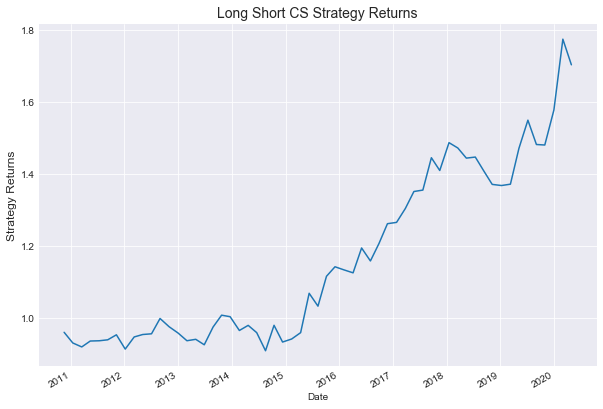

In [4]:
# Call the function strategy with below inputs
lookback_days = 180
hold_days = 41
strategy(filtered_stocks_prices, lookback_days, hold_days)

<a id='strategy2'></a> 
## Long-short cross-sectional momentum strategy with skip-days

Long trading signals are generated for top 10 percentile and short signals for bottom 10 percentile with <br>
a. Lookback days = 175 <br> 
b. Skip days = 5 <br> 
c. Holding days = 41

**Strategy logic:**
1. Calculate the stock returns over the lookback period by skipping 1 week (to avoid short term price reversal) and holding period. 
2. Rank the stock returns based on the lookback returns
3. Long stocks with highest 10 percentile lookback retuns and short stocks with lowest 10 percentile lookback returns
4. Include transation cost
5. Calculate the strategy returns 

In [5]:
def strategy_skip_recent(prices, lookback_days, skip_days, hold_days):

    # Calculate stock returns for the given lookback period with skip_days
    lookback_returns = prices.pct_change(lookback_days).shift(skip_days)
    hold_returns = prices.pct_change(hold_days).shift(-hold_days)

    n = len(lookback_returns.columns)
    lookback_rank = lookback_returns.dropna().rank(axis=1)

    def signal(rank):
        signal = np.where(rank > n*9/10, 1, np.nan)
        signal = np.where(rank < n/10, -1, signal)
        return signal

    lookback_signal = lookback_rank.apply(signal, axis=0)

    stocks_returns = hold_returns[lookback_days +
                                  skip_days::hold_days] * lookback_signal[::hold_days]

    trading_signal = lookback_signal[::hold_days]
    trading_signal = trading_signal.replace(np.nan, 0)
    cost = (0.001 * np.abs(trading_signal - trading_signal.shift(1)))
    stocks_returns = stocks_returns - cost

    portfolio_returns = stocks_returns.mean(axis=1)

    sharpe = np.mean(portfolio_returns) / \
        np.std(portfolio_returns)*((252/hold_days)**0.5)
    print('Sharpe Ratio %.2f' % sharpe)

    (portfolio_returns+1).cumprod().plot(figsize=(10, 7))
    plt.ylabel('Strategy Returns', fontsize=12)
    plt.title('Long Short Skip CS Strategy Returns', fontsize=14)
    plt.show()
    return portfolio_returns

Sharpe Ratio 0.76


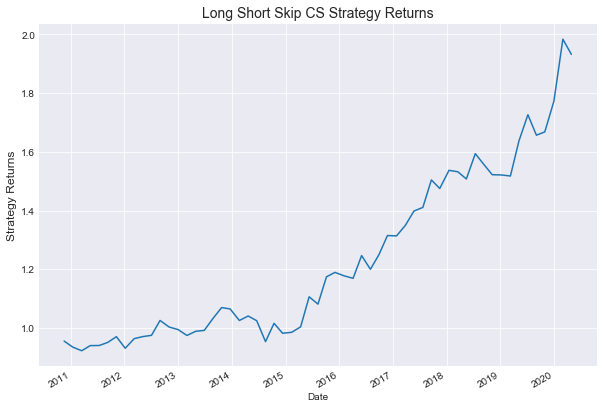

In [6]:
# Call the function strategy_skip_recent with below inputs
lookback_days = 175
skip_days = 5
hold_days = 41
portfolio_returns = strategy_skip_recent(
    filtered_stocks_prices, lookback_days, skip_days, hold_days)

<a id='strategy3'></a> 
## Long-only cross-sectional momentum strategy

Long only strategy on top 20 percentile stocks with <br> 
a. Lookback days = 175 <br>
b. Skip days = 5 <br>
c. Holding days = 41

**Strategy logic:**
1. Calculate the stock returns over the lookback period by skipping 1 week (to avoid short term price reversal) and holding period. 
2. Rank the stock returns based on the lookback returns
3. Long stocks with highest 20 percentile lookback retuns
4. Include trading cost
5. Calculate the strategy returns 

In [7]:
def strategy_long_only(prices, lookback_days, skip_days, hold_days):
    lookback_returns = prices.pct_change(lookback_days).shift(skip_days)
    hold_returns = prices.pct_change(hold_days).shift(-hold_days)

    n = len(lookback_returns.columns)
    lookback_rank = lookback_returns.dropna().rank(axis=1)

    def signal(rank):

        # Generate signal "1" for rank >80
        signal = np.where(rank > n*8/10, 1, np.nan)
        return signal

    lookback_signal = lookback_rank.apply(signal, axis=0)

    stocks_returns = hold_returns[lookback_days +
                                  skip_days::hold_days] * lookback_signal[::hold_days]

    trading_signal = lookback_signal[::hold_days]
    trading_signal = trading_signal.replace(np.nan, 0)
    cost = (0.001 * np.abs(trading_signal - trading_signal.shift(1)))
    stocks_returns = stocks_returns - cost

    portfolio_returns = stocks_returns.mean(axis=1)

    sharpe = np.mean(portfolio_returns) / \
        np.std(portfolio_returns)*((252/hold_days)**0.5)
    print('Sharpe Ratio %.2f' % sharpe)

    (portfolio_returns+1).cumprod().plot(figsize=(10, 7))
    plt.ylabel('Strategy Returns', fontsize=12)
    plt.title('Long Only CS Strategy Returns', fontsize=14)
    plt.show()

    return portfolio_returns

Sharpe Ratio 1.18


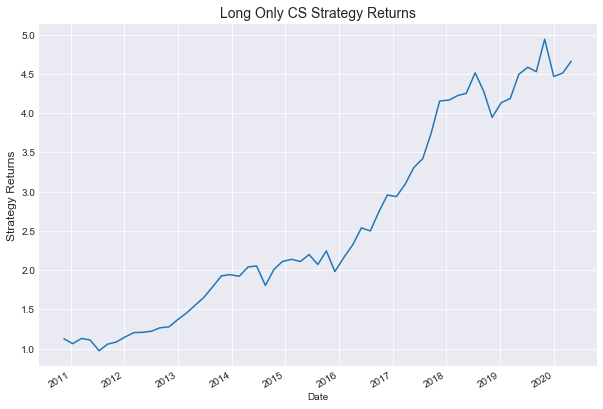

In [8]:
# Call the function strategy_long_only with below inputs
lookback_days = 175
skip_days = 5
hold_days = 41
portfolio_returns = strategy_long_only(
    filtered_stocks_prices, lookback_days, skip_days, hold_days)

portfolio_returns = portfolio_returns.dropna()

We can see that strategy had generated better returns when we introduced skip period. Long only momentum strategy performs even better than long short momentum with skip days but this strategy is slightly risky because it is exposed to market risks.

We will be focusing on cross sectional momentum strategies using fundamental data in the next section.<br><br>